# Overview

This notebook, together with the  corresponding source/simulation results, reproduces the figures published in 

Schünemann, Maik, Udo Ernst, and Marc Kesseböhmer.
A rigorous stochastic theory for spike pattern formation in recurrent neural networks with arbitrary connection topologies.
arXiv preprint arXiv:2202.02520 (2022).

# Influence of connection topology on avalanche scaling exponents on a periodic grid

Numerical avalanche size distributions in EHE-Torus simulation on a grid of  
lxl neurons with all to all coupling up to distance k and periodic boundary conditions. 

Simulations of the EHE dynamics for this connection topology and different coupling parameters
were performed on our cluster by running the file scripts/EHETorus_crit.sh 

The simulation scripts run Python jobs on the sun grid engine. The Python scripts use methods imported 
from the files in the src directory. The simulations of the model dynamics itself is written in high performance 
c++ code, which compiles to a pybind11 module. Functions to load the module are found in src/utils.py
and the simulation code is located in src/cpp/ehe_detailed.cpp. 

For the sparse connectivity on this 2d-grid, the simulate_model_grid function uses a list 
of connected neighbors of each node in the inner loop to update unit potentials after spikes. This list for this 
topology is generated by the get_conn_list_k(L,k) for a grid of size LxL and homogeneous coupling to all neighbors up to 
distance k. This function is copied to the code cell below for reference.


In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import mpmath as m

def is_conn_k(n1,n2,k):
    n1,n2 = (np.array(n1),np.array(n2))
    return 0 < np.max([min(Ns-abs(n),abs(n)) for n in n1-n2]) <= k

# need functions ind to index and back again     
def ind2node_k(Ns,i): 
    c1 = int(i/Ns)
    c2 = i-c1*Ns
    return [c1,c2]

def node2ind_k(Ns,node):
    c1,c2 = node
    c1 = c1%Ns#(Ns+c1)%Ns if c1 < 0 else c1%Ns
    c2 = c2%Ns#(Ns+c2)%Ns if c2 < 0 else c2
    return c1*Ns+c2


def get_conn_list_k(Ns,k):
    return np.array([[node2ind_k(Ns,(c1+o1,c2+o2)) for o1 in range(-k,k+1) for o2 in range(-k,k+1) if (abs(o1)+abs(o2)) != 0]
                       for c1,c2 in [ind2node_k(Ns,i) for i in range(Ns*Ns)]])

# 10-by-10 grid with periodic boundary conditions and couplings up to distance 1
conn = get_conn_list_k(5,1)
# each unit has 8 connected neighbors
conn.shape
print(conn[:5])


[[24 20 21  4  1  9  5  6]
 [20 21 22  0  2  5  6  7]
 [21 22 23  1  3  6  7  8]
 [22 23 24  2  4  7  8  9]
 [23 24 20  3  0  8  9  5]]


Utility functions used for plotting and comparison to homogeneous networks: 

In [2]:
def ehe_ana(alpha,N):
    return [m.exp(m.log((1/N))+m.log(m.binomial(N,n))+m.log(n*alpha/N)*(n-1)+
            m.log(1-(n*alpha/N))*(N-n-1)+m.log(((1-alpha)/(1-((N-1)/N)*alpha))))
                for n in range(1,N+1)]

In [3]:
def loglogplot(pdf,ax = None, figsize=(6,4),from_pdf=False,label=None):
    if from_pdf:
        norm_counts,unique = pdf
    else:
        points = pdf
        unique,counts = np.unique(points,return_counts=True)
        norm_counts = counts/np.sum(counts)
    if ax is None:
        f,ax = plt.subplots(figsize=figsize)
    ax.loglog(unique,norm_counts,label=label)
    #ax.set_xscale('log',nonposx='mask');
    #ax.set_yscale('log',nonposy='mask');
    #ax.scatter(unique,norm_counts,facecolors='none',edgecolors='b')
    return ax

## Plotting of simulation results

The results of the simulation are contained in the data directory. 


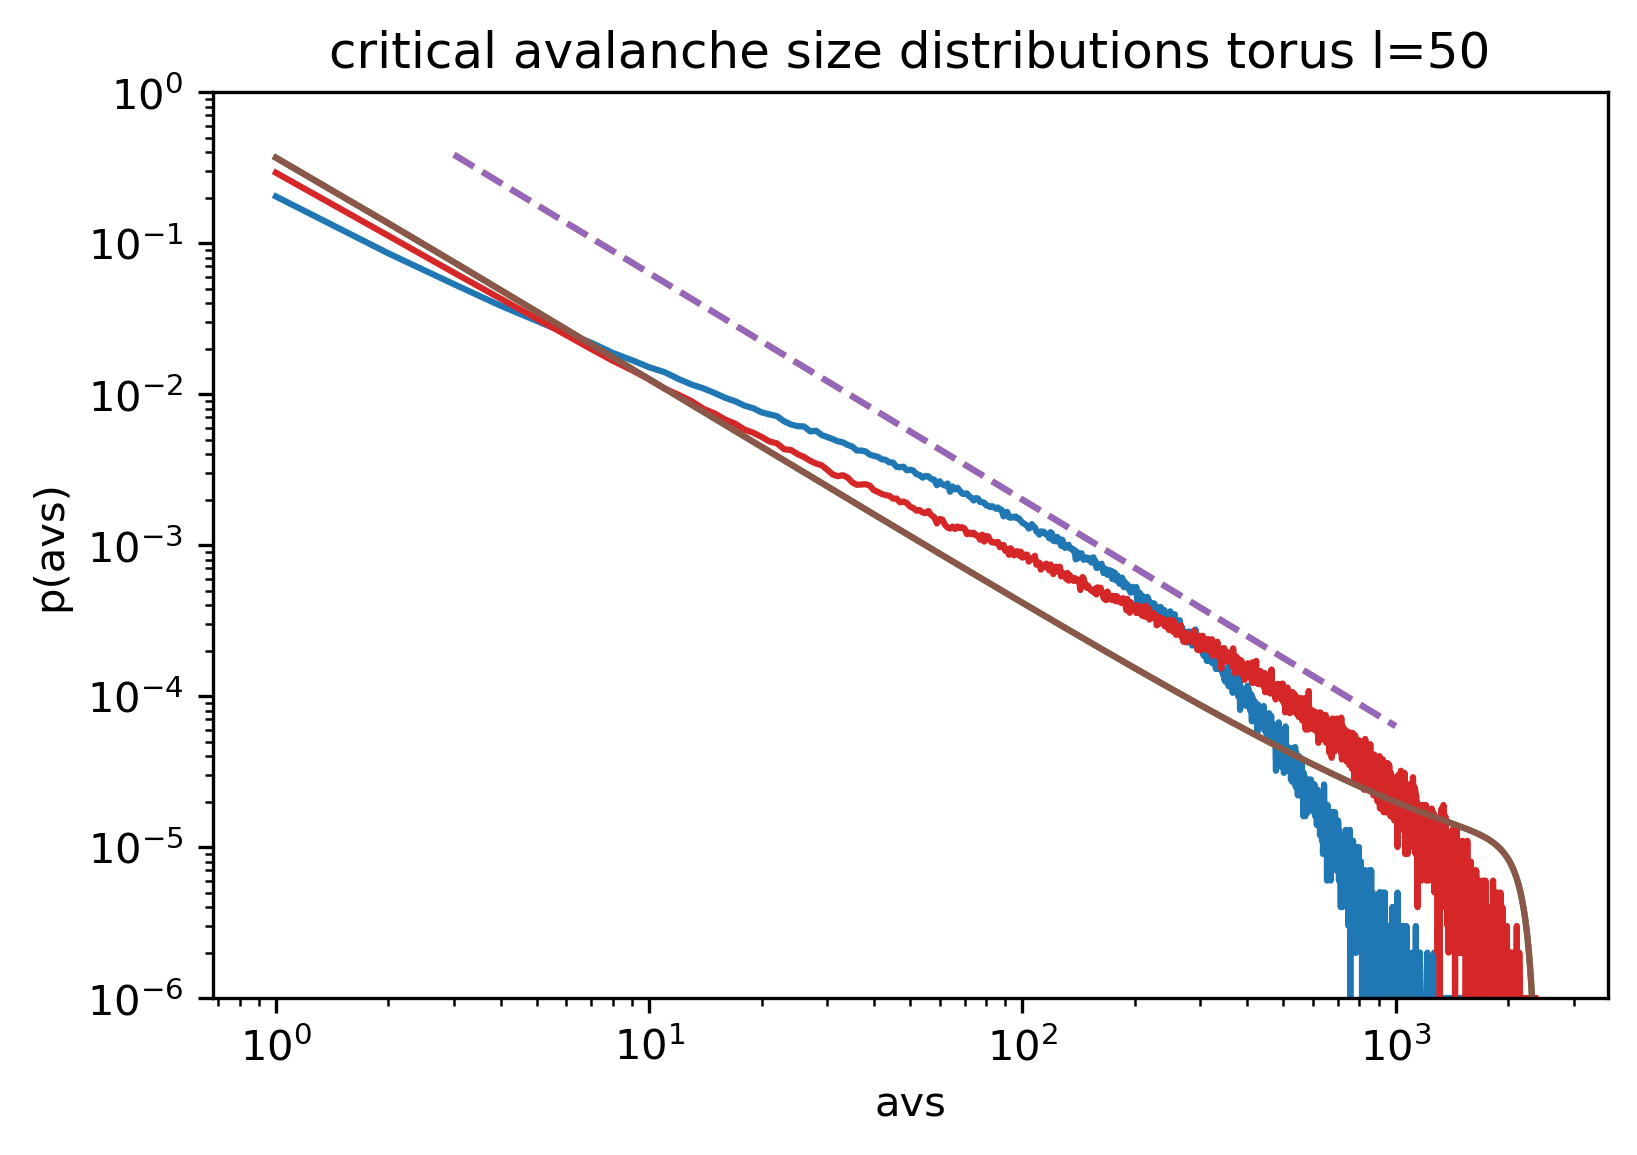

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
nt = 'data/EHETorus_crit/ehetorus_'

# analytical avalanche size distribution with homogeneous network WITHOUT SELF WEIGHTS
def ehe_ana_ws(alpha,N):
    w = alpha/(N-1)
    #return [sym.binomial(N-1,n-1)*(n*w)**(n-1)*(1-(n-1)*w)**(N-n-1)*(1-(N-1)*w)/(n*(1+w)**(N-2)*(1-(N-2)*w))
    #        for n in range(1,N+1)]
    return [m.exp(-m.log(n)+m.log(m.binomial(N-1,n-1))+m.log(n*alpha/(N-1))*(n-1)+
                 m.log(1-((n-1)*alpha/(N-1)))*(N-n-1)+m.log(((1-alpha)))-
                 (m.log(1+alpha/(N-1))*(N-2) + m.log(1 - ((N-2)*alpha)/(N-1))))
           for n in range(1,N+1)]

f,axs = plt.subplots(1,1)

# eal = {}
# for l in [50,100,200,300]:
#     print(l)
#     n = l**2
#     eal[l] = ehe_ana_ws(n*(n-np.sqrt(n-1)- 2)/(n**2 - 5*n+5),n)#(1-1/l,l**2)

# pickle.dump(eal,open('data/eal.pickle','wb'))


crit_alphas = pickle.load(open('data/crit_alphas','rb'))
eal = pickle.load(open('data/eal.pickle','rb'))

for l,ax in [(50,axs)]:#zip([50,100,200,300],axs.reshape([-1])):
    for k in [1,2]:#[1,2,3]
        a=crit_alphas[k][l] 
        avs = pickle.load(open(nt+str(l)+'_'+str(k)+'_'+str(a)+'.pickle','rb'))[0][0]
        loglogplot(avs,ax=ax,label='k='+str(k))
        xs = np.linspace(3,1000,1000)
        #ax.loglog(xs,0.4*xs**(-1),'--',label='alpha=1')
        ax.loglog(xs,2*xs**(-1.5),'--',label='alpha=1.5')
        ax.loglog(np.arange(l**2)+1,eal[l],label='hom')
        ax.set_ylim([1e-6,1])
        ax.grid(which='major')
        ax.set_xlabel('avs')
        ax.set_ylabel('p(avs)')
        ax.set_title('critical avalanche size distributions torus l='+str(l))



In [5]:
#from alpha_index to alpha value which was used in the curresponding numerical simulation
def ai2a(ai):
       ai = ai
       if ai < 40:
           return np.logspace(np.log10(0.95),np.log10(0.999),40)[ai]
       else:
           return np.logspace(np.log10(0.999),np.log10(0.999999),20)[ai-40]

# alpha index values for which power-law avalanche size distributions are seen
crit_alphas

{1: {50: 30, 100: 37, 200: 40, 300: 49},
 2: {50: 30, 100: 38, 200: 45, 300: 49},
 3: {50: 28, 100: 37, 200: 45, 300: 46}}

Text(0.5, 1.0, 'k dependence in  <avs>(n,alpha)~1/(1-n^c(k))')

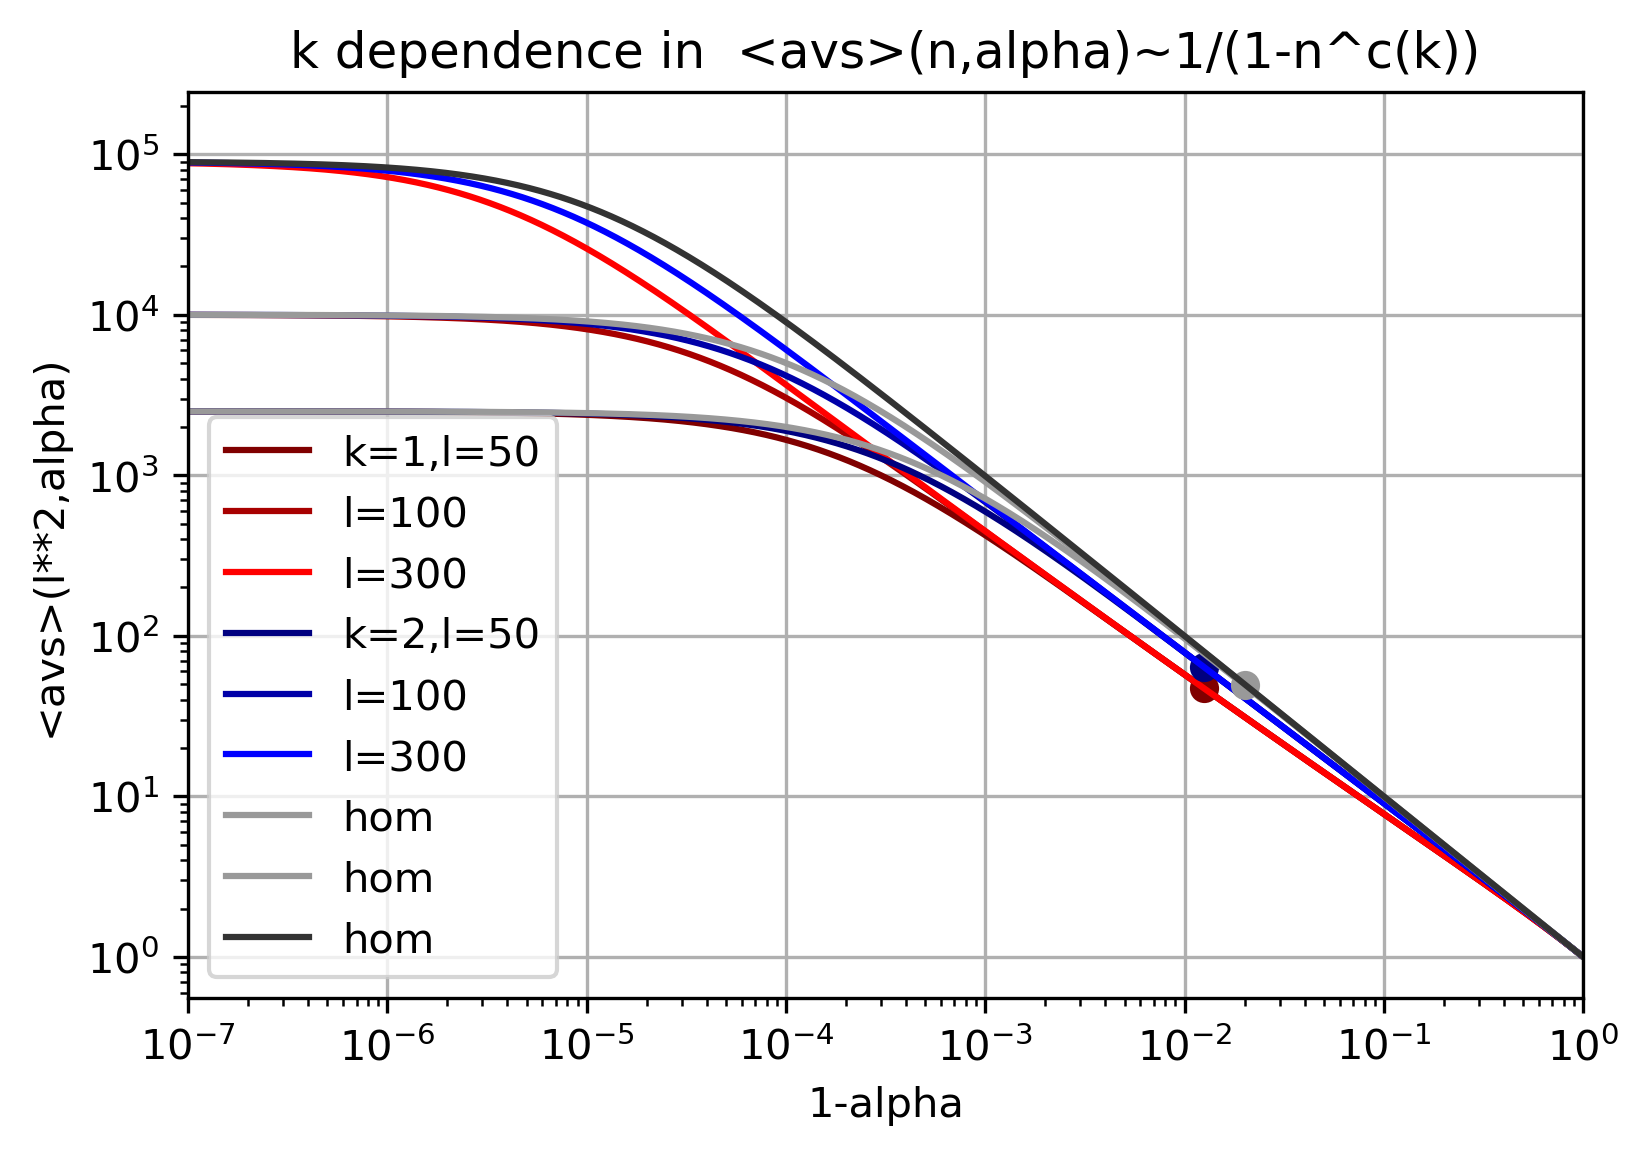

In [6]:
def psf_torus_k(l,k,alpha):
    c = alpha/((2*k+1)**2-1)
    psf = np.zeros((l,l))
    k1 = k+1
    psf[:k1,:k1] = -c
    psf[:k1,-k:] = -c
    psf[-k:,:k1] = -c
    psf[-k:,-k:] = -c
    psf[0,0] = 1
    return psf

def psf_torus_k_W(l,k,alpha):
    c = alpha/((2*k+1)**2-1)
    psf = np.zeros((l,l))
    k1 = k+1
    psf[:k1,:k1] = c
    psf[:k1,-k:] = c
    psf[-k:,:k1] = c
    psf[-k:,-k:] = c
    #psf[0,0] = 1
    return psf


def mean_avs_knn_torus(k,l,alpha):
    c  = alpha/((2*k+1)**2-1)
    col_sum_ana = 1/(1-alpha)
    Md_ana = 1/(l**2) * np.sum(1/np.real(np.fft.fft2(psf_torus_k(l,k,alpha))))
    return col_sum_ana/Md_ana


def mean_avs_knn_ring(k,n,alpha):
    c  = alpha*1/(2*k)
    col_sum_ana = 1/(1-alpha)
    Md_ana = 1/n * np.sum([1/(1-2*c*np.sum([mp.cos(2*np.pi*j*l/n) for l in np.arange(1,k+1)]))
                           for j in np.arange(n)])
    return col_sum_ana/Md_ana

def mean_avs_hom_ws(n,alpha):
    return (n-1+alpha)/((n-1)-(n-2)*alpha)

# alphas = np.linspace(0.1,0.999999999999999,100000)
# alphas = 1-10**(-np.linspace(0,16,10000))
# mavs_ana = {}
# for k in [1,3]:
#     mavs_ana[k] = {}
#     for l in [50,100,200,300]:
#         print(k,l)
#         mavs_ana[k][l] = [mean_avs_knn_torus(k,l,alpha) for alpha in alphas]

# pickle.dump([mavs_ana,alphas],open('data/mavs_ana_log.pickle','wb'))

mavs_ana,alphas = pickle.load(open('data/mavs_ana_log.pickle','rb'))

plt.figure()
color = {1:{50:(0.5,0,0),100:(0.66,0,0),200:(0.75,0,0),300:(1,0,0)},
         3:{50:(0,0.5,0),100:(0,0.66,0),200:(0,0.75,0),300:(0,1,0)},
         2:{50:(0,0,0.5),100:(0,0,0.66),200:(0,0,0.75),300:(0,0,1)},
         'hom':{50:(0.6,)*3,100:(0.6,)*3,200:(0.4,)*3,300:(0.2,)*3}}
    #plt.figure()
    
for k in [1,2]:
    for l in [50,100,300]:
        plt.loglog(1-alphas,mavs_ana[k][l],'-',color=color[k][l],
                   label=('k='+str(k)+',' if l==50 else '')+'l='+str(l))
        if l==50:
            alphann_idx = np.argmin(np.abs(alphas - ai2a(crit_alphas[k][l])))    
            plt.plot(1-alphas[alphann_idx],mavs_ana[k][l][alphann_idx],'o',color=color[k][l])
for l in [50,100,300]:
    plt.loglog(1-alphas,[mean_avs_hom_ws(l*l,alpha) for alpha in alphas],'-',
               color=color['hom'][l],label='hom')
    if l==50:
        n = l**2
        #ac = n*(n-np.sqrt(n-1)- 2)/(n**2 - 5*n+5)
        ac = (1-1/np.sqrt(n))
        plt.plot(1-ac,mean_avs_hom_ws(n,ac),'o',color=color['hom'][l])


plt.legend()
plt.xlim([1e-7,1])
plt.grid()
plt.xlabel('1-alpha')
plt.ylabel('<avs>(l**2,alpha)')
plt.title('k dependence in  <avs>(n,alpha)~1/(1-n^c(k))') 


# Analytical avalanche size distributions in simple networks

This section recreates the final figure of the paper, by analytically calculating the avalanche size distribution for the example networks. 
Ring and line networks as well as the two coupled homogeneous network example admit a closed form avalanche size distribution, whereas the distribution for the other small (n=16) networks is calculated by the class AvalancheSizeDistribution, which iterates over every avalanche 
assembly and applies the closed form equation to it. 

# closed form avalanche size distribution for two coupled subnetworks

In [7]:
def avs_dist_nk(Ns,a,ac,ns1,ns2,use_mult=True):
    if ns1+ns2 == 0:
       return (0,0)
    s1,s2,l1,l2 = ns1*a+(ns2)*ac,(ns2)*a+ns1*ac,Ns-ns1,Ns-(ns2)
    S1,S2 = 1-s1,1-s2
    mult = binom(Ns,ns1)*binom(Ns,ns2) 
    if mult <= 0:
        return (0,0)
    mult = mult if use_mult else 1
    ret = mult*ac*s1**ns1*s2**(ns2)*S1**(l1-1)*S2**(l2-1)*((S1-(a*l1))*(S2-(a*l2))-(l1*l2)*ac**2) / \
                     (ns1*(ns2)*(a**2+ac**2)+a*ac*(ns1**2+(ns2)**2)) 
    ret = ret/(2*Ns*(1-a*(2*Ns-1)+(a**2-ac**2)*(Ns*(Ns-1))))
    return (ret*ns1,ret*(ns2))

def avs_distmod2ovl(Ns,a,ac):
    res = []
    for n in range(1,2*Ns+1):
        probn = 0
        probn_log = 0
        for k in range(n+1):
            s1,s2,l1,l2 = k*a+(n-k)*ac,(n-k)*a+k*ac,Ns-k,Ns-(n-k)
            S1,S2 = 1-s1,1-s2
            mult = binom(Ns,k)*binom(Ns,n-k)
            pos = lambda x: x
            if mult >= 0:
               add = mult*n*ac*s1**k*s2**(n-k)*S1**(l1-1)*S2**(l2-1)*((S1-pos(a*l1))*(S2-pos(a*l2))-pos(l1*l2)*ac**2) / \
                      (k*(n-k)*(a**2+ac**2)+a*ac*(k**2+(n-k)**2))
               probn+=add 
        probn = probn/(2*Ns*(1-a*(2*Ns-1)+(a**2-ac**2)*(Ns*(Ns-1))))
        res.append(probn)
    return res

from scipy.special import gammaln

def log2comb(n, k):
    return (gammaln(n+1) - gammaln(n-k+1) - gammaln(k+1)) 

def avs_distmod2ovl_log(Ns,a,ac):
    res = []
    for n in range(1,2*Ns+1):
        probn = 0
        for k in range(n+1):
            s1,s2,l1,l2 = k*a+(n-k)*ac,(n-k)*a+k*ac,Ns-k,Ns-(n-k)
            S1,S2 = 1-s1,1-s2
            mult = log2comb(Ns,k)+log2comb(Ns,n-k)
            if mult >= 0:
               add = (mult+np.log(n)+np.log(ac)+np.log(s1)*k+np.log(s2)*(n-k)+np.log(S1)*(l1-1)+np.log(S2)*(l2-1)+
                      np.log(((S1-a*l1)*(S2-a*l2)-l1*l2*ac**2)))- np.log(k*(n-k)*(a**2+ac**2)+a*ac*(k**2+(n-k)**2))
               #import pdb;pdb.set_trace()       
               probn+=np.exp(add)
        #import pdb; pdb.set_trace()
        probn = probn/(2*Ns*(1-a*(2*Ns-1)+(a**2-ac**2)*(Ns*(Ns-1))))
        res.append(probn)
    return res



(1e-06, 0.5)

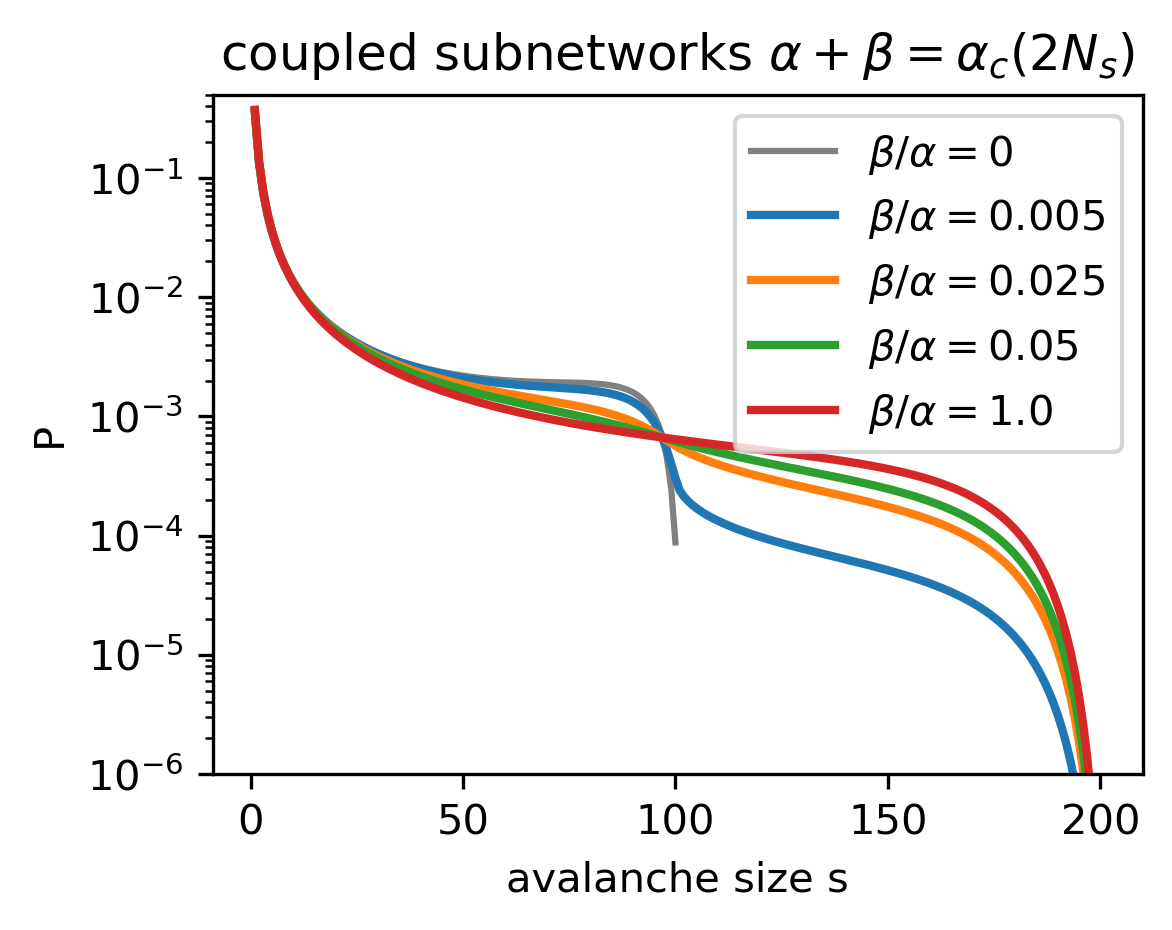

In [8]:
from scipy.special import binom
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

plt.figure(figsize=[4,3])
N_single = 100
N = 2*N_single
alpha_critical = lambda N: (1-1/np.sqrt(N))/N
alpha_N = alpha_critical(N)
acrit = alpha_N
alpha_N_single = alpha_critical(N_single)
acritt = alpha_N_single
alpha_N_single = alpha_N_single

plot = plt.semilogy

vals = [0.005,0.025,0.05,1]
a = 2*acrit

#a = alpha_N_single    
ehe_ana_dist = [((1/N_single)*binom(N_single,n)*(n*(a*N_single)/N_single)**(n-1)
            *(1-(n*(a*N_single)/N_single))**(N_single-n-1)*
            ((1-(a*N_single))
             /(1-((N_single-1)/N_single)*(a*N_single))))  for n in range(1,N_single+1)]
plot(np.arange(1,N_single+1),ehe_ana_dist,label=r'$\beta/\alpha = 0$',color='grey')

s97vals = []
mean_avss = []
for val in vals:
    ba = val
    ac_idx = 2*ba/(1+ba)
    a_idx = 2-ac_idx
    alpha = acrit*a_idx
    alpha_cross = acrit*ac_idx
    dist = avs_distmod2ovl_log(N_single,alpha,alpha_cross)
    s97vals.append(dist[97])
    mean_avss.append(np.sum([(i+1)*d for i,d in enumerate(dist)]))
    plot(np.arange(1,N+1),dist,
               label=(r'$\beta/\alpha = '
                      +str(np.round(np.array(alpha_cross/alpha),3))+'$'),linewidth=2)#,color=col)


plt.legend()
plt.xlabel('avalanche size s')
plt.ylabel('P')
plt.title(r'coupled subnetworks $\alpha+\beta =\alpha_{c}(2N_s)$')
plt.ylim([1e-6,0.5])

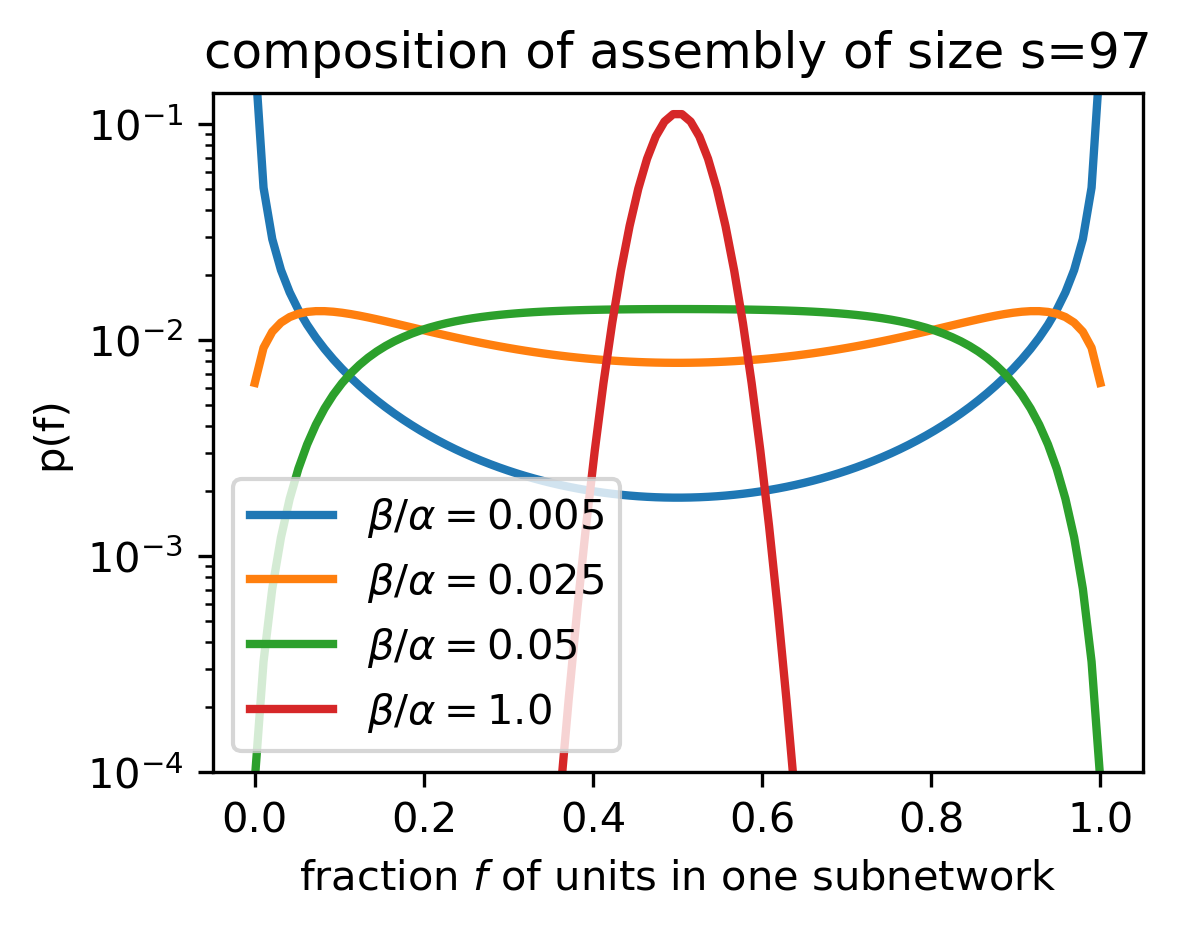

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
#from scipy.stats import binom

N_single = 100
N = 2*N_single
alpha_critical = lambda N: (1-1/np.sqrt(N))/N
alpha_N = alpha_critical(N)
acrit = alpha_N
alpha_N_single = alpha_critical(N_single)
acritt = alpha_N_single
alpha_N_single = 2*alpha_N
plt.figure(figsize=[4,3])#0.8*np.array([3.5,2.8]))

vals = [0.005,0.025,0.05,1]

stds = []

for val in vals:
    ba = val
    ac_idx = 2*ba/(1+ba)
    #ac_idx = val
    a_idx = 2-ac_idx
    alpha = acrit*(2-ac_idx)
    alpha_cross = acrit*ac_idx
    dist = avs_distmod2ovl_log(N_single,alpha,alpha_cross)
    detailed_avs = [[avs_dist_nk(N_single,alpha,alpha_cross,k,n-k) for k in range(n+1)] 
                     for n in range(1,N+1)]
    det_0 = [[x[0] for x in xr] for xr in detailed_avs]
    det_1 = [[x[1] for x in xr] for xr in detailed_avs]
    det = [[np.sum(x) for x in xr] for xr in detailed_avs]
    x = 97#N_single
    stds.append(np.std(det[x-1]/np.sum(det[x-1])))
    ub = len(det[x-1])
    plt.semilogy(np.arange(len(det[x-1]))[:ub]/x,(det[x-1]/np.sum(det[x-1]))[:ub],
                 label=(r'$\beta/\alpha = '+str(np.round(alpha_cross/alpha,4))+r'$'),linewidth=2)

plt.title('composition of assembly of size s='+str(x))
plt.xlabel('fraction $f$ of units in one subnetwork')
plt.ylabel('p(f)')
plt.ylim([1e-4,0.14])
plt.legend()

# small networks N=16

# Analytical calculation of avalanche size distribution in arbitrary networks

In [10]:
from itertools import chain, combinations
import sympy as sym
class AvalancheSizeDistribution():
    def __init__(self,W,deltaU=0.022,symbolic=False):
        self.W = W
        self.N = W.shape[0]
        self.deltaU = deltaU
        self.volumes = {}
        self.detailed_volumes = {}
        self.probs = {}
        self.det_func = np.linalg.det \
                        if not symbolic else lambda a: sym.Matrix(a).det()

    def detailed_volume(self,i_s,J):
        J = frozenset(J)
        vol = self.detailed_volumes.get((i_s,J))
        if vol is not None:
            return vol
        # Calculate volume of avalanche size with determinant formula
        det = self.det_func
        rem_u = list(J-set([i_s]))
        Jc = list(set(range(self.N))-J)
        vol_is = self.deltaU
        vol_J = 1
        if len(rem_u) > 0:
            m = np.diag([np.sum(self.W[i,list(J)]) for i in rem_u]) \
                                 - self.W[np.ix_(rem_u,rem_u)]
            vol_J = det(m) 
        vol_Jc = 1
        if len(Jc) > 0:
            m = np.diag([1 - np.sum(self.W[i,list(J)]) for i in Jc]) \
                                    - self.W[np.ix_(Jc,Jc)]
            vol_Jc = det(m)
        vol = vol_is*vol_J*vol_Jc
        self.detailed_volumes[(i_s,J)] = vol
        return vol

    def volume_size0_st(self,i):
        inds = list(set(range(self.N))-set([i]))
        vol = self.deltaU*self.det_func(np.eye(self.N-1,dtype=int) - self.W[np.ix_(inds,inds)])
        return vol


    def volume_size0(self):
        vol = 0
        for i in range(self.N):
            inds = list(set(range(self.N))-set([i]))
            vol += self.deltaU*self.det_func(np.eye(self.N-1,dtype=int) - self.W[np.ix_(inds,inds)])
        return vol

    def volume(self,n):
        vol = self.volumes.get(n)
        if vol is not None:
            return vol
        if n == -1:
            vol = self.noninh_volume()
            self.volumes[n] = vol
            return vol
        if n == 0:
            vol = self.volume_size0()
            self.volumes[n] = vol
            return vol
        vol = 0
        for units in combinations(range(self.N),n):
            for i_s in units:
                vol += self.detailed_volume(i_s,set(units))
        self.volumes[n] = vol
        return vol

    def prob(self,n):
        prob = self.probs.get(n)
        if prob is not None:
            return prob
        norm_n = self.volume(n)/self.N # 1/N prob to get activation to correct starting unit
        norm_0 = self.volume(0)/self.N
        prob = norm_n/(norm_0)
        self.probs[n] = prob
        return prob

    def avs_dist(self):
        for i in range(1,self.N+1):
            print(i)
            self.prob(i)
        return self.probs

Text(0, 0.5, 'p')

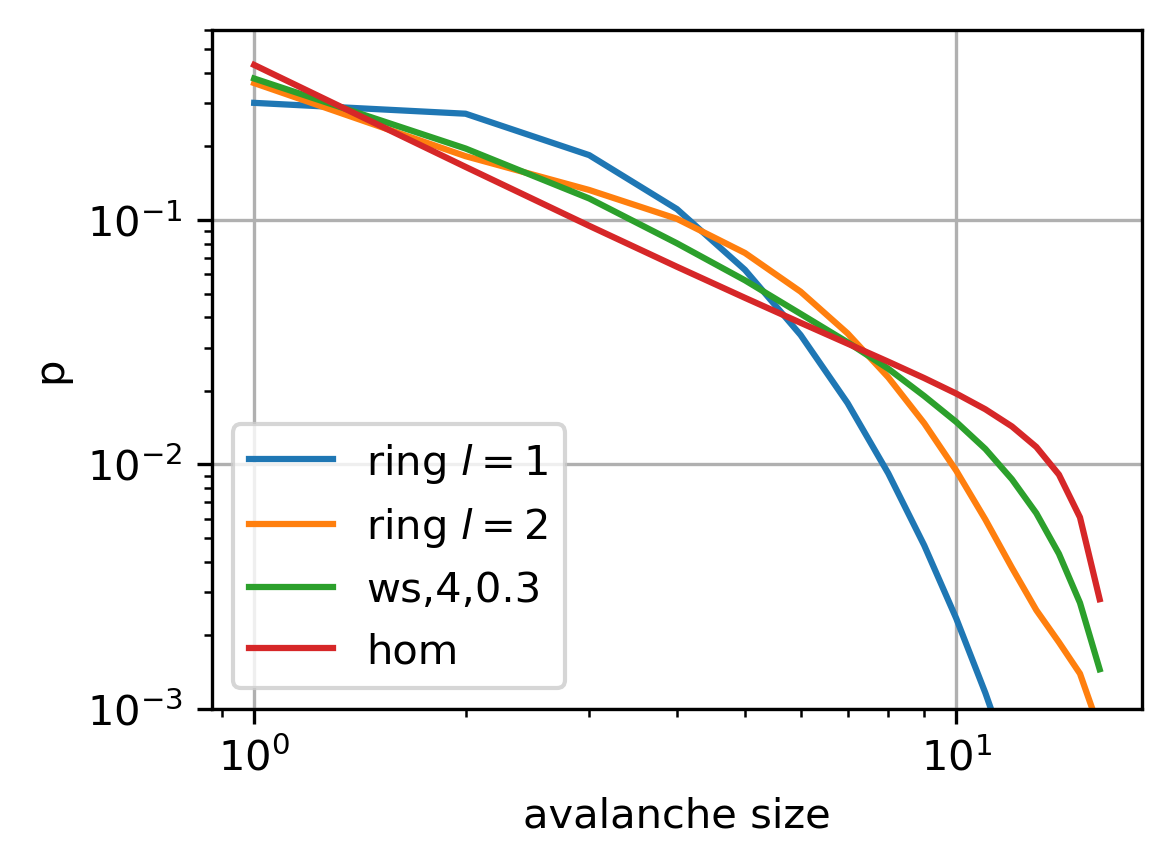

In [11]:
from itertools import chain, combinations
import sympy as sym
import pickle
import networkx as nx
from networkx.drawing.layout import circular_layout
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.random_graphs import barabasi_albert_graph

import mpmath as m

def W_ring(n,alpha,k=1,per_bc = True,self_activation=True,dtype=float):
    W = np.zeros((n,n),dtype=dtype)
    for i in range(n):
        #if i-1>=0:
        for j in range(1,k+1): 
            W[i,(i-j if i-j >= 0 else i-j+n)] = alpha
        if self_activation:    
            W[i,i] = alpha
        for j in range(1,k+1):
            W[i,(i+j if i+j<n else i+j-n)] = alpha
    return W

n = 16
alpha = 0.75
Wring = W_ring(n,alpha/2,self_activation=False)
Wline = Wring.copy()
Wline[0,-1] = 0
Wline[-1,0] = 0
Wline[0,1] = alpha
Wline[-1,-2] = alpha
Wring2 = W_ring(n,alpha/4,k=2,self_activation=False)
Gws = watts_strogatz_graph(n,4,0)
pos = circular_layout(Gws)
Gws = watts_strogatz_graph(n,4,0.3)
#plt.figure()
#nx.draw_networkx(Gws,pos=pos)
#plt.savefig('watts_strogatz_4_03.svg')
Wgs = np.asarray(nx.to_numpy_matrix(Gws,nodelist=sorted(Gws.nodes())))
Wgs = alpha * np.array([row/np.sum(row) for row in Wgs])
#pickle.dump(Wgs,open('example_Wgs_matrix_0.3','wb'))
Gws = watts_strogatz_graph(n,2,0)
#plt.figure()
#nx.draw_networkx(Gws,pos=pos)
#plt.savefig('ring_k=1.svg')
Gws = watts_strogatz_graph(n,4,0)
#plt.figure()
#nx.draw_networkx(Gws,pos=pos)
#plt.savefig('ring_k=2.svg')
Gba = barabasi_albert_graph(n,2)
#plt.figure()
#nx.draw_networkx(Gba,pos=pos)
Wba = np.asarray(nx.to_numpy_matrix(Gba,nodelist=sorted(Gba.nodes())))
Wba = alpha * np.array([row/np.sum(row) for row in Wba])
#pickle.dump(Wba,open('data/example_Wba_matrix','wb'))

# Ws = [Wring,Wring2]
# avsds = []
# dists = []
# plt.figure()
# for W in Ws:
#     avsd  = AvalancheSizeDistribution(W,deltaU=1)
#     dist = avsd.avs_dist()
#     avsds.append(avsd)
#     dists.append([dist[k] for k in np.arange(n)+1])
#     plt.loglog(np.arange(n)+1,dists[-1])
#     plt.pause(0.1)
# pickle.dump((Ws,avsds,dists),open('data/example_dists.pickle','wb'))


# avsd = AvalancheSizeDistribution(Wgs,deltaU=1)
# dist = avsd.avs_dist()
# %time dist_Wgs = [dist[k] for k in np.arange(n)+1]
# pickle.dump([avsd,dist],open('data/ws_4_03_avsd_dist.pickle','wb'))

plt.figure(figsize=[4,3])
Ws,avsds,dists = pickle.load(open('data/example_dists.pickle','rb'))
avsd,dist = pickle.load(open('data/ws_4_03_avsd_dist.pickle','rb'))
dist_Wgs = dist
dists.append(dist_Wgs)
labels = ['ring $l=1$','ring $l=2$','ws,4,0.3']
for dist,label in zip(np.array(dists,dtype=object),np.array(labels,dtype=object)):
    plt.loglog(np.arange(n)+1,dist,label=label)
plt.loglog(np.arange(n)+1,ehe_ana(alpha,n),label='hom')
plt.legend()
plt.grid('on')
plt.ylim([1e-3,0.6])
plt.xlabel('avalanche size')
plt.ylabel('p')

In [12]:
import numpy as np
import sympy as sym

# now calculate analytical closed form solution
def avs_ring(N,alpha):
    l1,l2 = 1/2 + (1/4 - alpha**2)**(1/2),1/2 - (1/4 - alpha**2)**(1/2)
    C = (1-alpha-l2)/(l1-l2)
    D = 1-C
    C_norm = (1-l2)/(l1-l2)
    D_norm = 1-C_norm
    norm = C_norm*l1**(N-1)+D_norm*l2**(N-1)
    def v_rec(n):
        if n == 1:
            return (1-2*alpha)
        if n == 2:
            return (1-alpha)**2 - alpha**2
        fn1 = C*l1**(n-1)+D*l2**(n-1)
        fn2 = C*l1**(n-2)+D*l2**(n-2)
        return (1-alpha)*fn1-alpha**2*fn2
    def v(n):
        if n == 0:
            return 1
        if n == 1:
            return 1-2*alpha
        return v_rec(n)
    ret = np.zeros((N,))
    for n in range(1,N+1):
        ret[n-1] = n*alpha**(n-1)*v(N-n)#/norm
    return (ret/norm,norm)


def avs_line(N,alpha):
    l1,l2 = 1/2 + (1/4 - alpha**2)**(1/2),1/2 - (1/4 - alpha**2)**(1/2)
    C = (1-alpha-l2)/(l1-l2)
    D = 1-C
    C_norm = (1-l2)/(l1-l2)
    D_norm = 1-C_norm
    norm_r = lambda N:C_norm*l1**(N)+D_norm*l2**(N)
    norm = np.sum([norm_r(j)*norm_r(N-j-1) for j in range(N)])/N  
    def v_rec(n):
        if n == 1:
            return (1-alpha)
        # if n == 2:
        #     return (1-alpha) - alpha**2
        # fn1 = C*l1**(n-1)+D*l2**(n-1)
        # fn2 = C*l1**(n-2)+D*l2**(n-2)
        # return (1-alpha)*fn1-alpha**2*fn2
        return C*l1**(n)+D*l2**(n)

    def v(n):
        if n == 0:
            return 1
        if n == 1:
            return 1-alpha
        return v_rec(n)
    ret = np.zeros((N,))
    for n in range(1,N+1):
        ret[n-1] = 1/N*n*alpha**(n-1)*np.sum([v(j)*v(N-n-j) for j in range(N-n+1)])#/norm
    return (ret/norm,norm)


# this code corresponds to how the closed form solutions are written up in the paper
# alpha is old_alpha*2
def avs_ring_new(N,alpha):
    a = np.sqrt(1-alpha**2)
    P0 = ((1+a)**N-(1-a)**N)/(2**N*a)
    def v(n):
        if n== 0:
            return 1
        if n<=2:
            return 1-alpha
        return a*((1+a)**n-(1-a)**n)/(2**n*(alpha+1))
    ret = np.zeros((N,))
    for n in range(1,N+1):
        ret[n-1] = n*(alpha/2)**(n-1)*v(N-n)#/norm
    ret = ret/P0
    return ret,P0


def avs_line_new(N,alpha):
    a = np.sqrt(1-alpha**2)
    norm_r = lambda N: ((1+a)**(N+1)-(1-a)**(N+1))/(2**(N+1)*a)
    P0 = np.sum([norm_r(j)*norm_r(N-j-1) for j in range(N)])/N
    def v(n):
        if n == 0:
            return 1
        if n == 1:
            return 1-alpha/2
        return ((1-alpha+a)*(1+a)**n+(alpha+a-1)*(1-a)**n)/(a*2**(n+1))
    ret = np.zeros((N,))
    for n in range(1,N+1):
        ret[n-1] = 1/N*n*(alpha/2)**(n-1)*np.sum([v(j)*v(N-n-j) for j in range(N-n+1)])#/norm
    return (ret/P0,P0)


# check that old and new implementations provide the same results
N = 10
alpha = 0.8
print(avs_ring(N,alpha/2))
print(avs_ring_new(N,alpha))
print('------')
print(avs_line(N,alpha/2))
print(avs_line_new(N,alpha))


(array([0.24999928, 0.24999642, 0.18748873, 0.1249696 , 0.07804878,
       0.04669194, 0.02691653, 0.01464845, 0.0065918 , 0.01464845]), 0.1789567999999999)
(array([0.24999928, 0.24999642, 0.18748873, 0.1249696 , 0.07804878,
       0.04669194, 0.02691653, 0.01464845, 0.0065918 , 0.01464845]), 0.1789567999999999)
------
(array([0.30357155, 0.27678641, 0.18750198, 0.11161174, 0.06139345,
       0.03182601, 0.01565551, 0.00729806, 0.00317819, 0.00117711]), 0.2227020799999999)
(array([0.30357155, 0.27678641, 0.18750198, 0.11161174, 0.06139345,
       0.03182601, 0.01565551, 0.00729806, 0.00317819, 0.00117711]), 0.22270207999999986)


Text(0.5, 1.0, 'Effect of edge deletion in ring network')

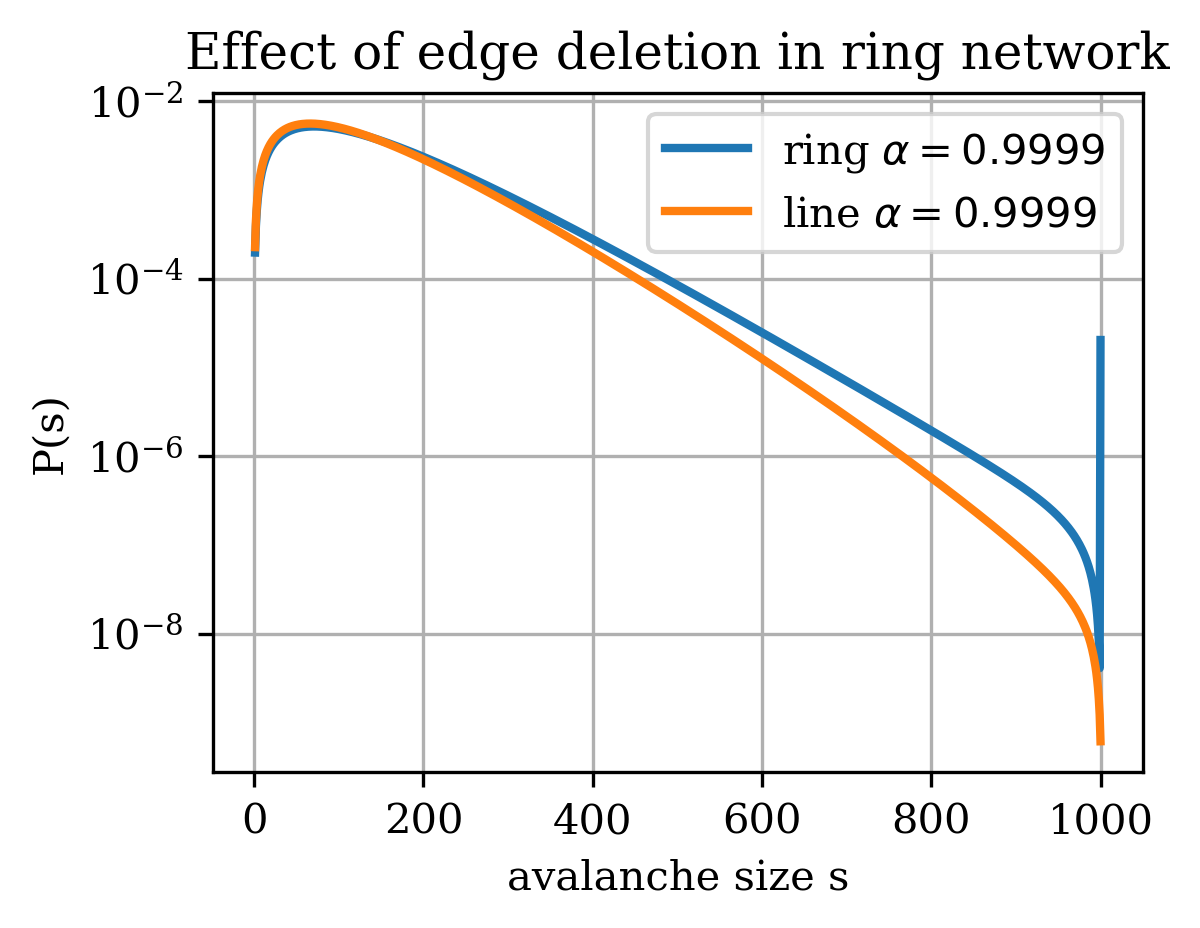

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
N = 1000
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=[4,3])
for alpha in [0.9999/2]:
    plt.title(str(alpha))
    dist_ring,norm = avs_ring(N,alpha)
    dist_line,norm = avs_line(N,alpha)
    plt.semilogy(np.arange(len(dist_ring))+1,dist_ring,label=r'ring $\alpha='+str(2*alpha)+'$',linewidth=2)#,marker='o')
    plt.semilogy(np.arange(len(dist_line))+1,dist_line,label=r'line $\alpha='+str(2*alpha)+'$',linewidth=2)#,marker='o')
    plt.grid('on')
    
plt.legend()
plt.xlabel('avalanche size s')
plt.ylabel('P(s)')
plt.title('Effect of edge deletion in ring network')